# Configuration Model

The Configuration Model is a random graph model that was originally designed to sample a graph uniformly over all graphs with a given sequence of degrees. 

The paramater of the model is a sequence of integers $\vec{k} = \{k_1, k_2, \dots, k_n\}$ where the sum of the entries is even. From this a graph $G = (V,E)$ with $V = \{1,2, \dots, n\}$ is constructed as follows:

1 Each node $i$ is assigned $k_i$ stubs (half-edges) <br>
2 While there are stubs left do the following: <br>
&emsp; 2a) Select two stubs $s_1$, $s_2$ uniformly at random from all still available stubs (without replacement) and 
     let $i_1, i_2$ be the nodes to which the stubs belong<br>
&emsp; 2b) Add the edge $(i_1, i_2)$ to the graph <br>
&emsp; 2c) Remove the selected stubs from the list of avaialable stubs <br>

The output is a graph where node $i$ has degree equal to $k_i$. However, please note that this graph might not be simple as a node can get connected to itself, creating self-loops, and multiple edges can be places between the same pair of nodes. However, if we condition on the resulting graph being simple, then it can be shown that this procedure indeed samples uniformly at random from all simple graph with degrees given by the sequence $\vec{k}$.

**Exercise 1** Implement the Configuration Model as a function ``CM(K)`` where `K` is an array of integers with even sum. Make sure it outputs the vertex list $V$ and the edge list $E$. Test the resulting code on the degree sequence `K=[2,2,2,2,3,3,3,3,4,4,5,5]`.

In [2]:
import numpy as np

In [3]:
def CM(K):
    V = []
    E = []
    
    n = len(K) # number of nodes
    m = int(sum(K)/2) # number of edges
    
    V = np.arange(n)
    
    ### We create a list of node indices where the index of node i is present K[i] times.
    ### This list represents the stubs.
    index = -1
    stubs = []
    for k in K:
        index += 1
        for s in range(0,k):
            stubs.append(index)
    #the previous 'for' goes through each node index and appends it to the list of stubs as many times as its degree.
    
    ### Shuffle the list of stubs
    rng = np.random.default_rng()
    rng.shuffle(stubs)
    
    ### Split the shuffeld list of stubs through the middle.
    sources = stubs[:m]
    targets = stubs[m:]
    
    ### Match the node indices of the two lists to form edges
    for i in range(0,m):
        e = (sources[i],targets[i])
        E.append(e)
        
    return V, E

In [4]:
### Test your code
K = [2,2,2,2,3,3,3,3,4,4,5,5]
(V,E) = CM(K)

print(f"The graph has {len(V)} nodes")
print(f"The edges of the graph are:\n {E}")

The graph has 12 nodes
The edges of the graph are:
 [(4, 10), (6, 9), (10, 6), (2, 3), (8, 11), (6, 8), (0, 10), (4, 10), (9, 9), (9, 0), (5, 11), (11, 2), (8, 10), (8, 5), (5, 4), (1, 7), (11, 11), (7, 3), (1, 7)]


## Configuration model in NetworkX

Depending on how you implemented the algorithm it might take very long to generate a large graph. Luckily the NetworkX library has us covered with the `configuration_model` function. Below is an example on the same degree sequence as for the test above.

**Note:** The general output of the `configuration_model` function is a `MultiGraph`. Here each edge is a tripple `(i,j,k)` where `i` and `j` are the node labels and `k` is the index for multiplicity. For example, if the edge $(1,2)$ is present twice, the list of edges will contain `(1,2,0)` and `(1,2,1)`.

In [5]:
import networkx as nx

In [6]:
cm_graph = nx.configuration_model(K)

print(f"The graph has {nx.number_of_nodes(cm_graph)} nodes")
print(f"The edges of the graph are:\n {list(cm_graph.edges)}")

The graph has 12 nodes
The edges of the graph are:
 [(0, 10, 0), (0, 10, 1), (1, 9, 0), (1, 9, 1), (2, 10, 0), (2, 8, 0), (3, 8, 0), (3, 9, 0), (4, 5, 0), (4, 6, 0), (4, 11, 0), (5, 10, 0), (5, 11, 0), (6, 8, 0), (6, 11, 0), (7, 10, 0), (7, 9, 0), (7, 11, 0), (8, 11, 0)]


## Getting a simple graph

The fact that the Configuration Model can give a multigraph is a bit problematic. There are two ways to deal with this:

&emsp; 1) repeat the algorithm until the result is a simple graph <br>
&emsp; 2) remove all self-loops and replace each multi-edge by a single edge <br>

The first option is often referred to as the Repeated Configuration Model (RCM) while the second one is known as the Erased Configuration Model (ECM). Please note that it could be that the degree sequence is such that there does not exist any simple graph with that sequece. Therefore, the RCM could run indefinitely (or in most case very long) before outputting a result. On the other hand, the ECM will always give a simple graph, but the degree sequence will not be the same as the one used as input for the model.

We can implement the ECM using NetworkX functions. First we can cast the `MultiGraph` to a simple `Graph`. This will take care of the multi-edges. Next we use `selfloop_edges` to get the self-loops in the graph and then remove them using `remove_edges_from`. The code is given below.

In [7]:
def ECM(K):
    cm_multi_graph = nx.configuration_model(K)
    cm_graph = nx.Graph(cm_multi_graph)
    cm_graph.remove_edges_from(nx.selfloop_edges(cm_graph))
    
    return cm_graph

In [10]:
### Test the code

ecm_graph = ECM(K)

degree_sequence = [d for v,d in ecm_graph.degree()]

print(f"The graph has {nx.number_of_nodes(ecm_graph)} nodes")
print(f"The edges of the graph are:\n {list(ecm_graph.edges)}")
print(f"The degree sequence is the same: {K == degree_sequence}")
print(f"The degree sequence is {degree_sequence}")


The graph has 12 nodes
The edges of the graph are:
 [(0, 8), (0, 6), (1, 11), (1, 3), (2, 11), (2, 9), (3, 8), (4, 8), (4, 10), (4, 6), (5, 8), (5, 10), (6, 9), (7, 11), (7, 10), (9, 11), (9, 10)]
The degree sequence is the same: False
The degree sequence is [2, 2, 2, 2, 3, 2, 3, 2, 4, 4, 4, 4]


## Generating graphs with a given degree distribution

While the Configuration Model is designed to generate graphs with a given degree sequence, it can also be used to generate graphs such that the empirical degree distribution converges to a given limit distribution. 

Suppose we are given a distribution $F$ on the integers. Then the procedure to create a simple graph of size $n$ is as follows:

&emsp; 1) Sample $n$ values $\{k_1, \dots, k_n\}$ from $F$ <br>
&emsp; 2) Check is the sum $\sum_{i = 1}^n D_i$ is even <br>
&emsp; 3) If not set $k_n = k_n +1$ <br>
&emsp; 4) Create a simple graph using ECM with input $\vec{k} = \{k_1, \dots, k_n\}$ <br>

It now follows, by an application of the law of large numbers (and some additional analysis), that for every fixed $k$,
$$
F_n(k) := \frac{1}{n} \sum_{i=1}^n \mathbf{1}\{d_i \le k\} \xrightarrow{\mathbb{P}} F(k) \quad \text{as } n \to \infty.
$$

**Note:** If we would have used the CM then the above result would be a direct consequence of the LLN, since (apart from the possibly added 1) each value is an iid sample from $F$. It remains true for ECM because it can be shown that the number of self-loops and excess edges scales less then $n$ and hence does not matter asymptotically.

**Exercise 2** Let $F$ be the Poisson distribution with mean $\lambda = 3$. Generate simple random graphs using the procedure described above for $n = 1000 \cdot 2^k$ with $k \in \{0,1,2,3,4\}$. Plot for each $k$ the resulting cdf $F_n$ as well as the limit cdf $F$ of the Poisson distribution in a the same figure. How large should your graph be for the empirical distribution to be close to the given limit?

**Note:** For sampling from the Poisson distribution you could use the `Poisson` object from the `scipy.stats` library by adding `from scipy.stats import poisson`. You can also use other functions, such as `cumfreq` to compute the empirical cdfs. See https://docs.scipy.org/doc/scipy/reference/stats.html for more info.

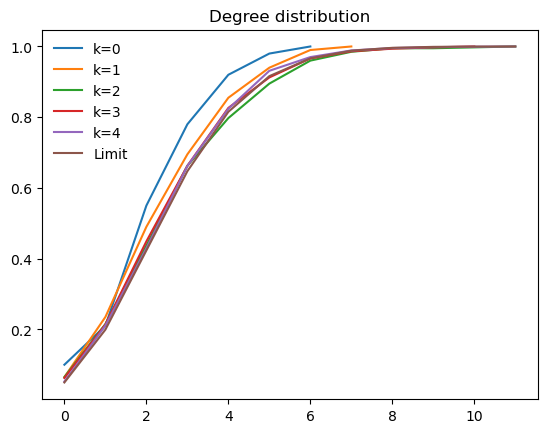

In [ ]:
### Solution

from scipy import stats
from scipy.stats import poisson
import matplotlib.pyplot as plt

### Function to generate ECM with degrees from a Poisson distribution
def ECM_poisson(N,mean):
    ### Sample from the Poisson distribution.
    degree_sequence = poisson.rvs(mean,size=N)

    ### Check if sum is even. If not, add 1 to the last degree.
    degree_sum = sum(degree_sequence)

    if (degree_sum % 2 == 1):
        last_degree = degree_sequence[N-1]
        degree_sequence[N-1] = last_degree+1

    ### Create a ECM graph with the given degree sequence
    pois_configuration_graph = ECM(degree_sequence)
    
    return pois_configuration_graph

### Create figure
fig = plt.figure()

### Keep track of the largest degree we see for the plot of the limit cdf
maximum = 0

### Loop over the different sizes
for k in range(0,5):
    n = 100*(2**k)
    pois_cm = ECM_poisson(n,3)
    
    degree_sequence = [degree for node, degree in pois_cm.degree()]
    
    max_degree = max(degree_sequence)
    if (max_degree > maximum):
        maximum = max_degree
    
    ### Compute the cummulative frequencies
    res = stats.cumfreq(degree_sequence,numbins=max_degree+1)
    
    ### Define the values for the x-axis
    x = np.arange(max_degree+1)
    
    ### Plot the cdf, which is the fraction of cummulative frequencies
    ### We also add a label
    plt.plot(x,res.cumcount/n,label=f'k={k}')

### Create object for the limit distribution
rv = poisson(3)

### Plot the limit cdf
x = np.arange(maximum+1)
plt.plot(x,rv.cdf(x),label='Limit')

### Add title and legend
plt.title('Degree distribution')
plt.legend(loc='best', frameon=False)

plt.show()